In [168]:
import numpy as np
import json
from scipy.optimize import least_squares
import dfbgn

In [ ]:
%run PES_incremental_exp.ipynb

In [169]:
list_data = np.load('data/hxoy_data_corr_290921.npy', allow_pickle=True) #reload
list_data = list_data[()]
print(len(list_data))

39


general f_obj, RMSE: $\sqrt{\frac{1}{n}\sum^n_{i=1}(V_{pred} - V_{ab initio})^2}$

In [175]:
## useful functions

def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(length):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

polynomial fit f_obj, minimize: $\sum_{i=1}^n |p(R_i) - V_i|^2$

In [229]:
'''
The models and objective functions
'''

np.random.seed(13) #reprodicuibility

## First proposed model:
f_morse_pot = lambda r,a: np.exp(-r/a)

def f_poly(x, c): #general polynomial, evaluated at x by horner's scheme
    y = c[-1]
    for i in range(len(c)-2, -1, -1):
        y = y*x + c[i]
    return y
    
def f_monomial_diatomic_pot(r, coeffs, morse=False): #monomial pot - permutationally invariant functional 
    #r := r_i, the ith distance
    #coeffs := the coefficients, in increasing order of polynomial (0,1,2,...)
    #evaluate the polynomial by horner's scheme:
    y = r
    v = coeffs[-1]
    for i in range(len(coeffs)-2, -1, -1):
        #i := power of the polynomial
        if morse and i > 0: #exclude the constant for morse
            y = f_morse_pot(r,i)
        v = v*y + coeffs[i]
    return v

def f_poly_obj(R, V, coeffs, F, poly_par): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], coeffs, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

## second proposed model:
def f_diatomic_pot_lr(C, *args):
    #C = fitted coefficients, [0:len(C)] is the polynomials' coefficients c_i, [-1] is the nonlinear decaying exp coeff r_0
    ##uses *args because dfbgn doesnt accept **kwargs
    #args[0] := r, the internuclear distance
    #args[1] := Z = (Z_1, Z_2), the tuple of nuclear charges
    #M, the max polynomial degree (= len(C)-2)
    r0 = C[-1]
    r = args[0]
    Z = args[1]
    M = len(C)-2
    y = np.exp(-r/r0)
    V = (Z[0]*Z[1])/r + C[0]
    
    poly_V = C[-2]
    for i in range(M-1, 1, -1): #M+1 since python excludes the last index
        poly_V = poly_V*y + C[i]
        #print(i, poly_V, C[i])
    '''
    #non horner version:
    poly_V = 0
    for i in range(2, M): 
        poly_V += C[i]*(y**(i-2))
        print(i, poly_V)
        #poly_V = poly_V*y + C[i-2]
    '''
    poly_V *= ((1-y)/(r**3 + C[1]))**2
    V += poly_V
    return V

def f_obj_diatomic_pot_lr(C, *args):
    #the objective function to be fitted, in RMSE form
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    f = args[0]
    V = args[1] #the energy vector
    R = args[2] #the distance vector
    Z = args[3] #nuclear charges of two atoms
    error = 0; n = len(V)
    for i in range(n):
        v_pred = f(C, R[i], Z)
        diff = (V[i]-v_pred)**2
        error += diff
    return np.sqrt([error/n])

In [136]:
#unit test
np.random.seed(13)
np.random.rand(5)

c = [0,3,2,1,2] #3x+2x^2+x^3
R = 2
v = f_monomial_diatomic_pot(R, c)
v_ = f_poly(R, c)
#print(v, v_)

### train on OH+ data of Xavier

In [13]:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#test on idx 1, train on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

In [14]:
#train using polynomial fit
M = 13 #max degree of polynomial
poly_par = {"M": M, "morse" : False}
#c = np.zeros(M)
#f = f_poly_obj(R, V, c, f_monomial_diatomic_pot, poly_par)
#print(f)
#test using numpy's polyfit:
c = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_obj(R, V, c[::-1], f_monomial_diatomic_pot, poly_par)
print("training error = ",e)
p = np.poly1d(c)
p_V = p(R)

training error =  5.382597244179081e-05


### test on OH+ data of Werner

In [30]:
idx = 1
R_test = list_data[qidxs[idx]]["R"]
V_test = list_data[qidxs[idx]]["V"]
p_V_test = p(R_test)
e = f_poly_obj(R_test, V_test, c[::-1], f_monomial_diatomic_pot, poly_par)
print("testing error = ",e)
print("testing RMSE = ",RMSE(V_test, p_V_test))

testing error =  2.9877720569352594e-05
testing RMSE =  0.005466051643494836


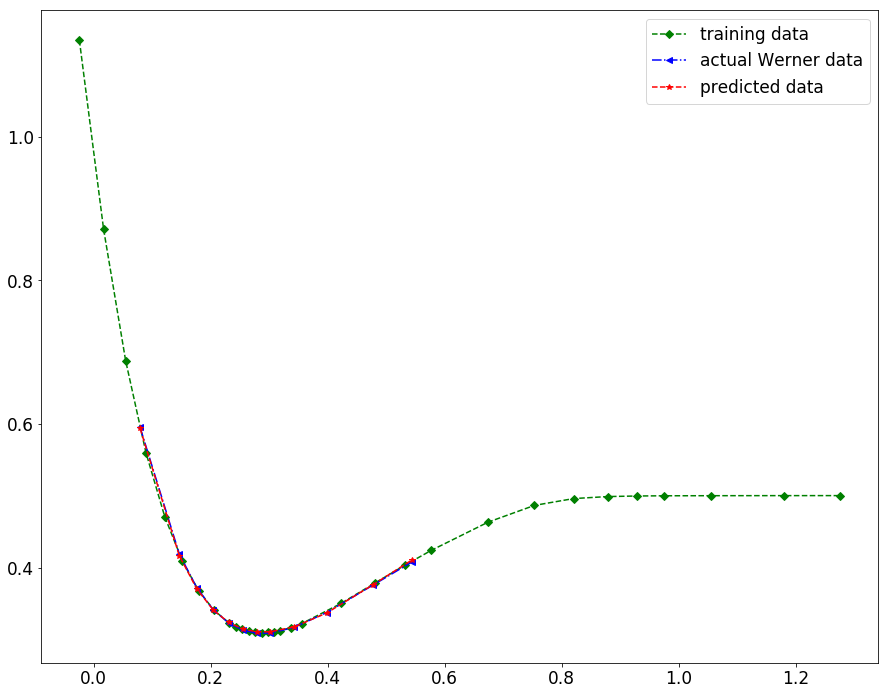

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), p_V_test, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

### Cubic spline

training RMSE = 0.0
testing RMSE = 0.0035166731030738677


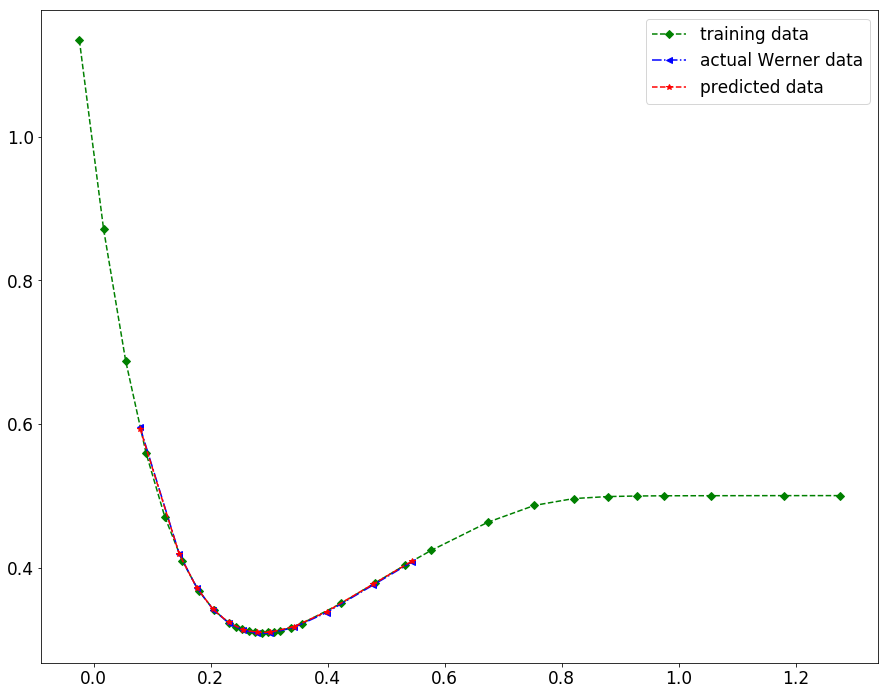

In [29]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
rmse = RMSE(V, V_pred)
print("training RMSE =",rmse)
plt.subplots(figsize=(15, 12))

#predict Werner's V:
V_pred = cs(R_test)
rmse = RMSE(V_test, V_pred)
print("testing RMSE =",rmse)
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

test RMSE = 0.008246436812486388


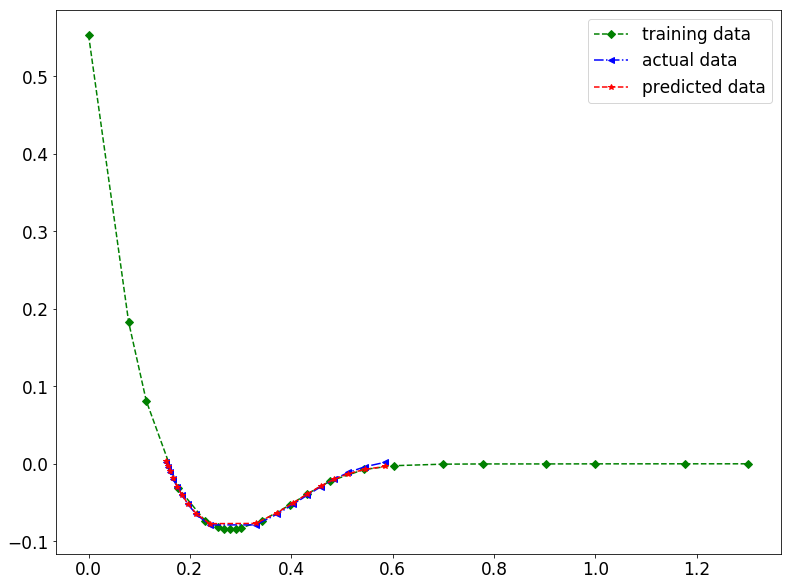

In [38]:
mol = "OH"
qidxs = query_many_vars_indices([mol, "$A^2\Sigma^+$"], ["mol", "state"], list_data)
newidxs = qidxs[1:3]
trainid = newidxs[0]; testid = newidxs[1]
R = list_data[trainid]["R"]; V = list_data[trainid]["V"] # training data
R_test = list_data[testid]["R"]; V_test = list_data[testid]["V"]# test data

cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R_test)
print("test RMSE =", RMSE(V_test, V_pred))

plt.subplots(figsize=(13, 10))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual data", "predicted data"])

### Model 041021

In [237]:
# Want to solve:
#   x1 + x2 - x1*x2 + 2 = 0
#   x1 * exp(-x2) - 1   = 0
def ftest(x,*args):
    a = args[0]; b=args[1]
    #print("f from args",x[0]+a+b)
    
def nonlinear_system(x, *args):
    f = args[0]; a=args[1]; b=args[2]
    f(x, a, b)
    return np.array([x[0] + x[1] - x[0]*x[1] + 2,
                     x[0] * np.exp(-x[1]) - 1.0])

# Define the objective function
def rosenbrock(x):
    return np.array([10.0 * (x[1] - x[0] ** 2), 1.0 - x[0]])

def rosenbrock2(x):
    return np.array([100.0*(x[1] - x[0]**2)**2 + (1.0 - x[0])**2])

# Define the starting point
x0 = np.array([-1.2, 1.0])
print(rosenbrock([1,1]))

# DFBGN is a randomized algorithm - set random seed for reproducibility
np.random.seed(0)

# Call DFBGN
soln = dfbgn.solve(rosenbrock, x0, fixed_block=2)
print(soln)

# Call DFBGN
soln = dfbgn.solve(rosenbrock2, x0, fixed_block=2)
print(soln)

res = least_squares(rosenbrock, x0)
print(res)

[0. 0.]
****** DFBGN Results ******
Solution xmin = [1.         0.99999999]
Residual vector = [-9.16629506e-08  0.00000000e+00]
Objective value f(xmin) = 8.402096506e-15
Needed 42 objective evaluations
No approximate Jacobian available
Exit flag = 0
Success: Objective is sufficiently small
****************************

****** DFBGN Results ******
Solution xmin = [-0.87290849  0.76842299]
Residual vector = [3.51195132]
Objective value f(xmin) = 12.33380207
Needed 300 objective evaluations
No approximate Jacobian available
Exit flag = 1
Warning (max evals): Objective has been called MAXFUN times
****************************

 active_mask: array([0., 0.])
        cost: 0.0
         fun: array([0., 0.])
        grad: array([0., 0.])
         jac: array([[-20.00000015,  10.        ],
       [ -1.        ,   0.        ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 25
        njev: 18
  optimality: 0.0
      status: 1
     success: True
           x: array([1., 1

In [159]:
C = np.array([1,2,3,4,5,1,2,3,4,5,1])
r = 2
Z = (8, 1)
f_diatomic_pot_lr(C, r, Z)

5.027186123867218

In [238]:
#fit using dfbgn:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#train and test on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]
C = np.zeros(4)+1e-6 #to avoid division by 0
Z = (1, 8) #atomic number of atom_1 and atom_2
#f = f_obj_diatomic_pot_lr(C, f_diatomic_pot_lr, V, R, Z)
#print(f)
soln = dfbgn.solve(f_obj_diatomic_pot_lr, C, args=(f_diatomic_pot_lr, V, R, Z))
print(soln)

res = least_squares(f_obj_diatomic_pot_lr, C, args=(f_diatomic_pot_lr, V, R, Z))
print(res)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


****** DFBGN Results ******
Solution xmin = [-0.05999455 -0.00042815  0.06857558  0.0412063 ]
Residual vector = [3.77528151]
Objective value f(xmin) = 14.25275049
Needed 3 objective evaluations
No approximate Jacobian available
Exit flag = -3
Error (linear algebra): Failed to build interpolation model while building adaptive model
****************************

 active_mask: array([0., 0., 0., 0.])
        cost: 1.2408955683270935
         fun: array([1.57537016])
        grad: array([-0.00586406, -0.03671231,  0.03580456,  0.        ])
         jac: array([[-0.00372234, -0.02330393,  0.02272771,  0.        ]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 400
        njev: 395
  optimality: 0.036712309584882384
      status: 0
     success: False
           x: array([-2.65868089e+00,  1.50828384e-01, -5.84217115e+00,  1.00000000e-06])
